# RNN Classification Test
Trying to classify the age of an author based on a written blogpost

## 1. Import libraries

In [ ]:
!pip install torchtext==0.4

     |████████████████████████████████| 61kB 5.7MB/s 
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import os
import time

import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import plotly.graph_objs as go
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict, OrderedDict, Counter
import operator

Mounted at /content/drive
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Load and preprocces the dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Language, speech and dialogue processing/Datasets/df_pan_train.csv') 

In [ ]:
#df = df.sample(3000000)
df

,Unnamed: 0,age_group,gender,id,lang,text
0,0,20s,female,d7e7217319dd1754a34e4be964c6b3dd,en,The utilization of this item of therapy gear i...
1,1,20s,female,849d98f28dabb279afbf1be03df0f49b,en,"Before, an individual additional learn about t..."
2,2,30s,male,5e1a6c0fc8f86acf120241458d28f04e,en,The vending device organization is one particu...
3,3,30s,male,f71aa8b90e58ff67b546762046d170c,en,National Treasure - three Stars (Excellent)<br...
4,4,20s,female,85bc7205cb05428c1fc39389f27280c2,en,"Based in Southwest Louisiana, the Law Office o..."
...,...,...,...,...,...,...
401988,413559,30s,male,8d1958f26ba95ffabe7b70c5373fd767,en,"<a href=""http://en.pan.netcom/go/out/url=-aHR0..."
401989,413560,20s,male,b613b93baf2f0876432d87c2f7019603,en,Microsoft Office 2010 is the newest model (as ...
401990,413561,20s,male,e673d02e09b0e1a0ba76ea2a04488d9a,en,Prior to beginning the set up process of the a...
401991,413562,20s,male,72c552f17d363ef334a34b130c7745a5,en,Prior to starting up the installation process ...


In [ ]:
ages = df["age_group"].unique().tolist()
ages.sort()
age_dict = {}
for age in ages:
  age_dict[age] = df.loc[df['age_group'] == age]

for key, value in age_dict.items():
  age_dict[key] = value
  
print(age_dict)

{'10s':         Unnamed: 0  ...                                               text
20              20  ...  Instantly you will notice people with the purc...
21              21  ...  Too many people throw in the towel early on be...
29              29  ...  he Best Site for Free Money Offers and Competi...
31              31  ...  No make a difference what your good reasons we...
32              32  ...  <strong>;Salam.\n<br />;<br />;okay, first, I ...
...            ...  ...                                                ...
401933      413504  ...  You want to fix your PS3 and that's it. Anothe...
401934      413505  ...  In recent decades, there are many game systems...
401935      413506  ...  Super Mario brothers 3 is another major game w...
401959      413530  ...  Men and women through every wander of life are...
401979      413550  ...  I LIKE SURFING AND NEW! ADD ME AND WE CAN BECO...

[27428 rows x 6 columns], '20s':         Unnamed: 0  ...                                   

In [ ]:
# Same range as in pan13 dataset

dataframes_10s = []
dataframes_20s = []
dataframes_30s = []
for key, value in age_dict.items():
  if key == '10s':
    dataframes_10s.append(value)
  elif key == '20s':
    dataframes_20s.append(value)
  elif '30s':
    dataframes_30s.append(value)

df_10s = pd.concat(dataframes_10s)
df_20s = pd.concat(dataframes_20s)
df_30s = pd.concat(dataframes_30s)

all_dataframes = [df_10s, df_20s, df_30s]

min_len = len(all_dataframes[0])

for df in all_dataframes:
  if len(df) < min_len:
    min_len = len(df)

df_10s["age"] = 0
df_20s["age"] = 1
df_30s["age"] = 2

all_dataframes = [df_10s.sample(min_len), df_20s.sample(min_len), df_30s.sample(min_len)]


df = pd.concat(all_dataframes)

## 3. Create n_grams from the text (Optional)

In [ ]:
# lemmatizing function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# remove stopwords
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text
    
def tokenize(text):
    wrong_words = ["urllink", "nbsp"]
    tokens = [token for token in text.split(" ") if token != "" and token not in wrong_words]
    return tokens

def lowered(s):
    return s.lower()

def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [ ]:
df["text"] = df["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)


# ngram = 2
# for i, text in enumerate(df['text']):
#   if type(df['text'].iloc[i]) != list:
#     lower = lowered(text)
#     non_alph = remove_nonalph(lower)
#     tokens = tokenize(non_alph)
#     # no_stopwords = remove_stopwords(tokens)
#     # lemma = lemmatize(no_stopwords)
#     # ngrams = generate_ngrams(lemma, ngram)
#     df['text'].iloc[i] = tokens
print(df['text'].iloc[0])
print(df['text'])

['imperfect', 'me', 'but', 'blive', 'in', 'ur', 'self']
317468            [imperfect, me, but, blive, in, ur, self]
149925    [justin, bieber, was, labeled, a, security, ri...
270843    [the, computer, has, wrought, many, changes, t...
121581    [in, nonmitoticendocrinology, treated, cells, ...
150952    [i, volunteered, to, work, at, the, gulou, sub...
                                ...                        
277271    [god, has, never, given, up, will, never, give...
104839    [a, href, http, en, pan, netcom, go, out, url,...
138973    [all, of, us, h, v, view, on, football, predic...
200509    [nonetheless, at, hats, plus, the, idea, of, k...
352820    [if, i, had, to, do, it, all, over, once, more...
Name: text, Length: 82284, dtype: object


In [ ]:
df.index = range(len(df))


In [ ]:
df


,Unnamed: 0,age_group,gender,id,lang,text,age
0,326536,10s,male,8e50a18b7a12569c11f7aad160da5e5d,en,"[imperfect, me, but, blive, in, ur, self]",0
1,154354,10s,female,b6b768bed9ab74a61b25d58045b4a31d,en,"[justin, bieber, was, labeled, a, security, ri...",0
2,278767,10s,female,248279cdf1b669b1f845701e64517c53,en,"[the, computer, has, wrought, many, changes, t...",0
3,125207,10s,female,7342a59fb7ff737c70de82821dffcdbb,en,"[in, nonmitoticendocrinology, treated, cells, ...",0
4,155413,10s,female,f107afbbeaf85b73c5903f0bea089357,en,"[i, volunteered, to, work, at, the, gulou, sub...",0
...,...,...,...,...,...,...,...
82279,285366,30s,male,442b4e034a62e54dfeaf70117d8266da,en,"[god, has, never, given, up, will, never, give...",2
82280,108007,30s,male,dc31477c2f4f03e39b98db8fcf09c61c,en,"[a, href, http, en, pan, netcom, go, out, url,...",2
82281,143118,30s,female,7508839f47968a31b33b58fb8b4975e1,en,"[all, of, us, h, v, view, on, football, predic...",2
82282,206457,30s,male,39c82e2193248c9012b3d029631afd89,en,"[nonetheless, at, hats, plus, the, idea, of, k...",2


In [ ]:
# AMOUNT_OF_CATEGORIES = 5
# df = df.assign(age_group=pd.qcut(df['age'], AMOUNT_OF_CATEGORIES, labels=[i for i in range(AMOUNT_OF_CATEGORIES)]))

In [ ]:
# hist_trace = go.Histogram(x=df['age_group'])
# go.Figure(hist_trace).show()

Pre processing data loader

In [ ]:
class_choice = 'age'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1
print(sorted(classdict))

### PROBLEM: ALS IK DIT WISSEL NAAR NORMAL SORT DAN IS DE UITKOMST INEENS ANDERS???
classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))
#classdict = dict(sorted(classdict.items()))
print('classdict:')
print(classdict)

[0, 1, 2]
classdict:
{0: 27428, 1: 27428, 2: 27428}


## 7. Vocabulary dictionary
Making a dict of all the words in the dataset and mapping each unique word to a unique number

In [ ]:
vocabdict = defaultdict(int)   

for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))
print(vocabdict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# WORD TO NUMBER MAPPING
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 8. Mapping text column to numbers (tensor)

In [ ]:
import numpy as np
text_int_list = []
text_lengths = []
for i, text in enumerate(df['text']):
  newtext = []
  lens = []
  for word in text:
    newtext.append(int(wordmap[word]))
  text_lengths.append(len(newtext))
  text_int_list.append(newtext)
average_len = int(sum(text_lengths) / len(text_lengths))
df["lengths"] = text_lengths

encoding_padded = []
for ints in text_int_list:
  N = average_len
  zeros = np.zeros(N, dtype=int)
  encoded = zeros
  length = min(N, len(ints))
  encoded[:length] = ints[:length]
  encoding_padded.append(np.array((encoded, len(ints))))

df["encoded"] = encoding_padded
df



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,Unnamed: 0,age_group,gender,id,lang,text,age,lengths,encoded
0,326536,10s,male,8e50a18b7a12569c11f7aad160da5e5d,en,"[imperfect, me, but, blive, in, ur, self]",0,7,"[[21630, 140, 57, 112112, 8, 1624, 396, 0, 0, ..."
1,154354,10s,female,b6b768bed9ab74a61b25d58045b4a31d,en,"[justin, bieber, was, labeled, a, security, ri...",0,219,"[[7712, 10185, 101, 6148, 2, 638, 1010, 40, 2,..."
2,278767,10s,female,248279cdf1b669b1f845701e64517c53,en,"[the, computer, has, wrought, many, changes, t...",0,439,"[[0, 295, 72, 7062, 85, 1413, 1, 0, 190, 136, ..."
3,125207,10s,female,7342a59fb7ff737c70de82821dffcdbb,en,"[in, nonmitoticendocrinology, treated, cells, ...",0,706,"[[8, 169109, 3307, 1642, 18227, 29848, 1488, 6..."
4,155413,10s,female,f107afbbeaf85b73c5903f0bea089357,en,"[i, volunteered, to, work, at, the, gulou, sub...",0,529,"[[42, 23992, 1, 129, 45, 0, 91859, 10892, 3135..."
...,...,...,...,...,...,...,...,...,...
82279,285366,30s,male,442b4e034a62e54dfeaf70117d8266da,en,"[god, has, never, given, up, will, never, give...",2,18,"[[1398, 72, 300, 635, 62, 22, 300, 165, 62, 20..."
82280,108007,30s,male,dc31477c2f4f03e39b98db8fcf09c61c,en,"[a, href, http, en, pan, netcom, go, out, url,...",2,27,"[[2, 27, 15, 30, 28, 33, 25, 18, 26, 15, 66, 5..."
82281,143118,30s,female,7508839f47968a31b33b58fb8b4975e1,en,"[all, of, us, h, v, view, on, football, predic...",2,574,"[[41, 5, 201, 1455, 1321, 760, 20, 1736, 10938..."
82282,206457,30s,male,39c82e2193248c9012b3d029631afd89,en,"[nonetheless, at, hats, plus, the, idea, of, k...",2,709,"[[678, 45, 4023, 352, 0, 470, 5, 1153, 4023, 2..."


In [ ]:
X = list(df['encoded'])
y = list(df['age'])
print(X[0])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

[array([ 21630,    140,     57, 112112,      8,   1624,    396,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
     

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BlogDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
train_ds = BlogDataset(X_train, y_train)
valid_ds = BlogDataset(X_valid, y_valid)

**TO-DO:**

*   Confusion matrix
*   Activation words





In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/PAN_rnn_confusion_matrix.png')
    


In [ ]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.long().to(device)
            l = l.to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            x, y, l = x.to(device), y.to(device), l.to(device)
            loss = F.cross_entropy(y_pred, y).to(device)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        train_loss = sum_loss/total
        print('Epoch: %d' %(i + 1))
        print(f'\tLoss: {train_loss:.4f}(train)\t')
        print(f'\tLoss: {val_loss:.4f}(valid)\t|\tAcc: {val_acc * 100:.1f}%(valid) | \tRMSE: {val_rmse * 100:.1f}(valid)')
        if i == (epochs-1):
          predictions, labels = validation_metrics(model, val_dl, True)
          conf_matrix = confusion_matrix(np.array(labels), np.array(predictions), labels=[0, 1, 2])
          np.set_printoptions(precision=2)
          # Plot non-normalized confusion matrix
          #plt.figure()
          plot_confusion_matrix(conf_matrix, classes=['10s', '20s', '30s'], normalize=True, title='PAN13 RNN Confusion matrix, with normalization')




def validation_metrics (model, valid_dl, last_epoch=False):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    predictions = []
    labels = []
    for x, y, l in valid_dl:
        x,y,l = x.to(device), y.to(device), l.to(device)
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(1)
        predict = pred.to('cpu')
        label = y.to('cpu')
        predictions.extend(predict)
        labels.extend(label)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), y.unsqueeze(-1).cpu()))*y.shape[0]
    if last_epoch == False:
      return sum_loss/total, correct/total, sum_rmse/total
    else:
      return predictions, labels



In [ ]:
batch_size = 256
vocab_size = len(vocabdict)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
print(f"Vocab size: {vocab_size}")

# Rule of thumb voor embed dim volgens: 
# (https://datascience.stackexchange.com/questions/31109/ratio-between-embedded-vector-dimensions-and-vocabulary-size)

embedding_dimensions =  int(vocab_size**0.25)

model_fixed =  LSTM_fixed_len(vocab_size, embedding_dimensions, 50).to(device)

Vocab size: 370324


Epoch: 1
	Loss: 1.0799(train)	
	Loss: 1.0422(valid)	|	Acc: 45.7%(valid) | 	RMSE: 110.8(valid)
Epoch: 2
	Loss: 1.0278(train)	
	Loss: 1.0290(valid)	|	Acc: 46.9%(valid) | 	RMSE: 107.7(valid)
Epoch: 3
	Loss: 0.9687(train)	
	Loss: 1.0194(valid)	|	Acc: 48.2%(valid) | 	RMSE: 107.8(valid)
Epoch: 4
	Loss: 0.8566(train)	
	Loss: 1.0518(valid)	|	Acc: 48.4%(valid) | 	RMSE: 108.3(valid)
Epoch: 5
	Loss: 0.7275(train)	
	Loss: 1.1436(valid)	|	Acc: 50.0%(valid) | 	RMSE: 104.9(valid)
Epoch: 6
	Loss: 0.6122(train)	
	Loss: 1.2249(valid)	|	Acc: 50.7%(valid) | 	RMSE: 103.6(valid)
Epoch: 7
	Loss: 0.5211(train)	
	Loss: 1.3522(valid)	|	Acc: 50.4%(valid) | 	RMSE: 104.6(valid)
Epoch: 8
	Loss: 0.4505(train)	
	Loss: 1.4181(valid)	|	Acc: 50.8%(valid) | 	RMSE: 103.7(valid)
Epoch: 9
	Loss: 0.3940(train)	
	Loss: 1.4797(valid)	|	Acc: 50.0%(valid) | 	RMSE: 105.5(valid)
Epoch: 10
	Loss: 0.3495(train)	
	Loss: 1.5605(valid)	|	Acc: 50.5%(valid) | 	RMSE: 103.1(valid)
Epoch: 11
	Loss: 0.3110(train)	
	Loss: 1.6533(valid)	|	Acc:

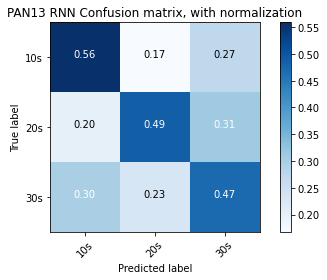

In [ ]:
train_model(model_fixed, epochs=50, lr=0.01)